In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm 
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchsummary import summary

# Подготовка тренировочного датасета

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 2060
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [3]:
device

device(type='cuda')

In [4]:
pd.read_csv('../data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [3]:
categories = pd.read_csv('../data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [4]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [5]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (img_train).
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.files = os.listdir(self.img_dir)
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.files[idx]
        img_id =img_id.split('.')[0]
        # img_id1 = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        # label = self.labels.iloc[idx, 1]  # target_feature (метка)
        label = self.labels.loc[self.labels['img_id'] == int(img_id), 'target_feature'].values[0]

        # Загружаем изображение
        # img_path = os.path.join(self.img_dir, 'aug_'+str(img_id)+'.jpg')
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label, img_id
    
    def __len__(self):
        return len(self.files)


# Создание папки с аугментированными изображениями и ответами к ним

Перед аугментацией, разобъем наш датасет на две части

In [9]:
#Класс для разделения
class SplitPFileToVal:
    def __init__(self, path_to_dir, path_to_new_dir_val, path_to_new_dir_train, p:float):
        """
        Создаёт 2 новые папки: Для валидации - % от всех изображений, для трейна - все остальное. 
        Нужно для отделения части датасета, для val данных

        path_to_dir: Папка с изображениями. (img_train)
        path_to_new_dir_val: Путь до новой папки, можно не создавать вручную.
        path_to_new_dir_train: Путь до новой папки, можно не создавать вручную.
        p: % изображений, которые будут отделены для валидационного датасета
        """

        #Проверка, введеного %
        if not isinstance(p, float):
            raise TypeError("% должен быть float")
        if p <= 0 or p > 1:
            raise ValueError("% должен быть в диапозоне: 0 < p <= 1")
        self.p = p

        self.path_to_dir = path_to_dir
        self.files = os.listdir(self.path_to_dir)
        self.path_to_new_dir_val = path_to_new_dir_val
        self.path_to_new_dir_train = path_to_new_dir_train



        # Создаем папки для сохранения
        if os.path.exists(path_to_new_dir_val):
            shutil.rmtree(path_to_new_dir_val)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_val, exist_ok=True)

        if os.path.exists(path_to_new_dir_train):
            shutil.rmtree(path_to_new_dir_train)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_train, exist_ok=True)

    def split(self):
        len_val = int(len(self.files)*self.p)
        len_train = len(self.files) - len_val
        with tqdm(total=len_val, desc="Отделение валидационных данных", unit="img") as pbar:
            for _ in range(len_val):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_val+f'/{file}')
                self.files.pop(idx)

                pbar.update(1)

        with tqdm(total=len_train, desc="Отделение тренировочных данных", unit="img") as pbar:
            for _ in range(len_train):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_train+f'/{file}')
                self.files.pop(idx)
                
                pbar.update(1)

        print(f"\nОтделено {len_val} изображений, для валидации в папку: {self.path_to_new_dir_val}")
        print(f"Отделено {len_train} изображений, для тренировки в папку: {self.path_to_new_dir_train}")



In [10]:
#Использование разделения
spliter = SplitPFileToVal(
    path_to_dir='../data/img_train',
    path_to_new_dir_val='../data/val_dataset',
    path_to_new_dir_train='../data/train_dataset',
    p=0.1
)

spliter.split()

Отделение тренировочных данных: 100%|██████████| 11131/11131 [00:34<00:00, 319.18img/s]


Отделено 1236 изображений, для валидации в папку: ../data/val_dataset
Отделено 11131 изображений, для тренировки в папку: ../data/train_dataset


In [11]:
#Класс для создания аугментаций
class AugmentedDatasetSaver:
    def __init__(self, original_train_dataset, csv_path, augmentation_transform, new_train_dataset_path, output_csv_path, augment_count):
        """
        Создает и сохраняет аугментированный датасет из тренировочного.
        Также создает csv с ответами на аугментированный датасет, сохраняет ответы из train_answers

        original_train_dataset: Исходный датасет (torch Dataset).
        csv_path: путь к csv с ответами
        augmentation_transform: Трансформации для аугментации.
        new_train_dataset_path: Папка, куда будут сохранены данные.
        output_csv_path: Путь, куда будет сохранена csv
        augment_count: Количество аугментированных изображений, которые нужно создать.
        """
        self.original_train_dataset_path = original_train_dataset
        self.augmentation_transform = augmentation_transform
        self.new_train_dataset_path = new_train_dataset_path
        self.output_csv_path = output_csv_path
        self.original_labels = pd.read_csv(csv_path)

        
        if augment_count >= len(original_train_dataset):
            print("Введеный augment_count > длины датасета")
        self.augment_count = augment_count


        # Создаем папку для сохранения
        if os.path.exists(new_train_dataset_path):
            shutil.rmtree(new_train_dataset_path)  # Удаляем папку, если она уже существует
        os.makedirs(new_train_dataset_path, exist_ok=True)

    def save(self):
        new_entries = []
        max_id = self.original_labels['img_id'].max()
        with tqdm(total=self.augment_count, desc="Создание аугментированных данных", unit="img") as pbar:
            for i in range(self.augment_count):
                # Выбираем случайное изображение из оригинального датасета
                image, label, img_id = random.choice(self.original_train_dataset_path)

                # Преобразуем в тензор, если это PIL.Image
                if not isinstance(image, Image.Image):
                    raise ValueError(f"Unsupported image format: {type(image)}")

                # Применяем аугментацию
                augmented_image = self.augmentation_transform(image)

                

                # Генерируем имя файла, сохраняя оригинальное имя с префиксом
                img_id = max_id+i+1

                new_entries.append({'img_id': int(img_id), 'target_feature': label})

                img_save_path = os.path.join(self.new_train_dataset_path, f"{img_id}.jpg")

                # Преобразуем аугментированный тензор обратно в PIL.Image и сохраняем
                augmented_image = transforms.ToPILImage()(augmented_image)  # Перевод тензора в PIL
                augmented_image.save(img_save_path)

                pbar.update(1)
        # Создание DataFrame для новых данных
        augmented_df = pd.DataFrame(new_entries)
        combined_df = pd.concat([self.original_labels, augmented_df], ignore_index=True)
        combined_df.to_csv(self.output_csv_path, index=False)
        
        print(f"CSV файл с метками успешно сохранён в: {self.output_csv_path}")
        print(f"\nСохранено {self.augment_count} аугментированных изображений в папке: {self.new_train_dataset_path}")


In [12]:
#transform для аугментации
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=25), 
    transforms.ToTensor(),  # Преобразование в тензор для работы с RandomErasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

In [13]:
# Загружаем датасет, для тренировки
original_traint_dataset = HumanPoseDataset(
    img_dir='../data/train_dataset',
    csv_file='../data/train_answers.csv',
    transform=None  # Оставляем без изменений
)

# Папка для сохранения аугментированного датасета
save_dir = "../data/augmented_only_dataset"

# Количество аугментированных изображений
augment_count = 11000 

# Создаем и сохраняем 
dataset_saver = AugmentedDatasetSaver(
    original_train_dataset=original_traint_dataset,
    augmentation_transform=augmentation_transform,
    csv_path='../data/train_answers.csv',
    new_train_dataset_path=save_dir,
    augment_count=augment_count,
    output_csv_path='../data/augmented_train_answers.csv'
)

In [14]:
# Создание аугментированных файлов
dataset_saver.save()

Создание аугментированных данных: 100%|██████████| 11000/11000 [04:16<00:00, 42.96img/s]

CSV файл с метками успешно сохранён в: ../data/augmented_train_answers.csv

Сохранено 11000 аугментированных изображений в папке: ../data/augmented_only_dataset


Проверка, что все создалось в нужном кол-ве

In [15]:
line_count = sum(1 for line in open('../data/augmented_train_answers.csv')) - sum(1 for line in open('../data/train_answers.csv'))
if augment_count == line_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {line_count}(line_count)')

OK


In [16]:
aug_file_count = len(os.listdir("../data/augmented_only_dataset"))
if augment_count == aug_file_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {aug_file_count}(aug_file_count)')

OK


## Cоединение папки с аугментированными картинками и тренировочным датасетом в новую папку.

Удаляет папку по пути, который указан в path_augmented_only_dataset

In [17]:
def merge_folders(path_train_dataset, path_augmented_only_dataset, path_destination_folder):
    """
    Объединяет две папки с картинками в одну. УДАЛЯЕТ папку path_augmented_only_dataset

    :param path_train_dataset: Путь к первой исходной папке
    :param source_folder2: Путь ко второй исходной папке
    :param destination_folder: Путь к папке назначения
    """
    # Создаем папку назначения, если она не существует
    if os.path.exists(path_destination_folder):
        shutil.rmtree(path_destination_folder)  # Удаляем папку, если она уже существует
    os.makedirs(path_destination_folder, exist_ok=True)
    
    # Функция для копирования файлов из папки
    def copy_files_from_folder(folder):
        with tqdm(total=len(os.listdir(folder)), desc=f"Копирование из {folder}", unit="img") as pbar:
            for file_name in os.listdir(folder):
                source_path = os.path.join(folder, file_name)
                dest_path = os.path.join(path_destination_folder, file_name)
                
                # Проверяем, является ли элемент файлом
                if os.path.isfile(source_path):
                    if os.path.exists(dest_path):
                        raise KeyError('файл с таким именем уже существует в папке назначения')
                    shutil.copy2(source_path, dest_path)
                pbar.update(1)
    
    # Копируем файлы из обеих папок
    copy_files_from_folder(path_train_dataset)
    copy_files_from_folder(path_augmented_only_dataset)
    #Удаляем папку с аугментацией
    shutil.rmtree(path_augmented_only_dataset)

In [18]:
path_train_dataset = '../data/train_dataset'
path_augmented_only_dataset = "../data/augmented_only_dataset"
destination_folder = "../data/augmented_and_train_dataset"

In [19]:
merge_folders(path_train_dataset, path_augmented_only_dataset, destination_folder)

Копирование из ../data/augmented_only_dataset: 100%|██████████| 11000/11000 [00:02<00:00, 3990.32img/s]


In [20]:
expected_count = aug_file_count+len(os.listdir("../data/train_dataset"))
quantity_count = len(os.listdir("../data/augmented_and_train_dataset"))
if expected_count == quantity_count:
    print('OK')
else:
    print(f'Ожидалось {expected_count}(expected_count)\n Получилось {quantity_count}(quantity_count)')

OK


По итогу получилось:   
папка img_train -- картинки в оригинале,  
папка train_dataset -- часть датасета, для обучения,  
папка val_dataset -- часть датасета, для валидации,   
папка augmented_and_train_dataset -- augmented_only_dataset+img_train,   
augmented_train_answers.csv -- ответы на все папки  

# Начало работы с моделью

In [ ]:
# RANDOM_SEED = 52
# generator = torch.Generator().manual_seed(RANDOM_SEED)

In [8]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 8


In [6]:
# transform_train = transforms.Compose([
#     transforms.Resize((227, 227)), # тк в ауг датасете есть фото без аугментации
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
val_dataset = HumanPoseDataset(
    img_dir='../data/val_dataset',
    csv_file='../data/train_answers.csv',
    transform=transform
)

train_dataset = HumanPoseDataset(
    img_dir='../data/augmented_and_train_dataset',
    csv_file='../data/augmented_train_answers.csv',
    transform=transform
)



# train_dataset, _ = random_split(dataset_train, [int(0.9*len(dataset_train)), len(dataset_train) - int(0.9*len(dataset_train))], generator)
# _, val_dataset = random_split(dataset_val, [int(0.9*len(dataset_val)), len(dataset_val) - int(0.9*len(dataset_val))], generator)

In [31]:
train_dataset[0]

(tensor([[[ 2.0434,  1.1872,  0.0398,  ...,  2.1804,  2.1462,  1.7694],
          [ 1.8893,  1.5639,  0.2967,  ...,  2.1462,  1.9920,  1.5639],
          [ 2.0263,  1.8893,  0.8276,  ...,  1.3755,  1.4269,  1.1015],
          ...,
          [ 1.2214,  1.2899,  1.3584,  ...,  0.5364,  0.4679,  0.4166],
          [ 1.2557,  1.3413,  1.3584,  ...,  0.5193,  0.4337,  0.3823],
          [ 1.2899,  1.3413,  1.3584,  ...,  0.5193,  0.4337,  0.3823]],
 
         [[ 0.6954,  0.1702, -0.5476,  ...,  2.3761,  2.3936,  2.1310],
          [ 0.5203,  0.4678, -0.3025,  ...,  2.3936,  2.3410,  2.0434],
          [ 0.6254,  0.6779,  0.0826,  ...,  1.6933,  1.8683,  1.6583],
          ...,
          [ 0.3978,  0.4678,  0.5028,  ...,  0.0651, -0.0399, -0.0924],
          [ 0.4328,  0.5028,  0.5378,  ...,  0.0126, -0.0749, -0.1275],
          [ 0.4678,  0.5203,  0.5553,  ...,  0.0126, -0.0749, -0.1275]],
 
         [[-0.3578, -0.5844, -0.6715,  ...,  2.6226,  2.6226,  2.5180],
          [-0.4798, -0.4101,

In [9]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label, img_id= dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7351656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping in

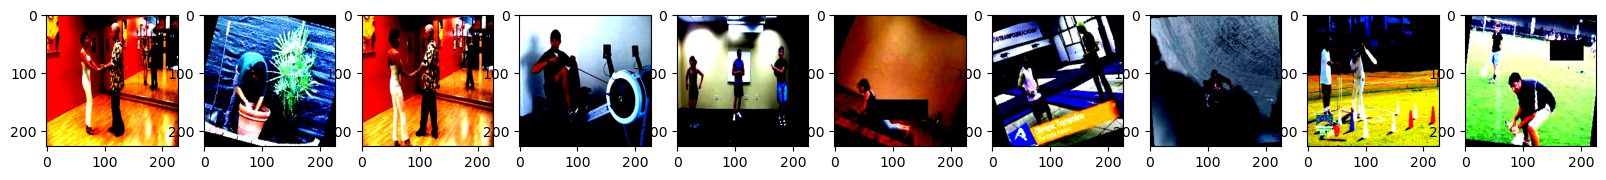

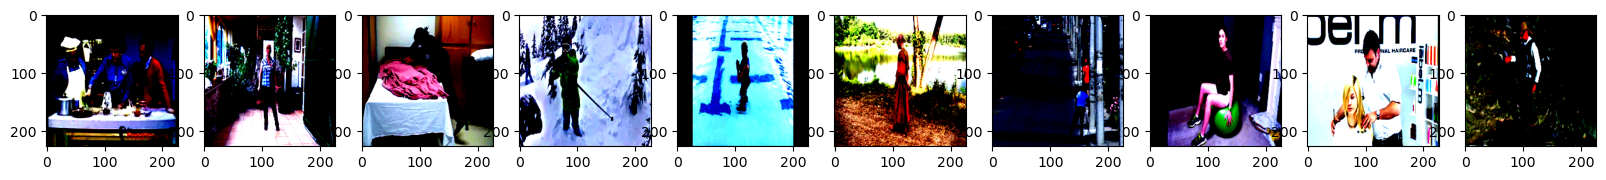

In [11]:
# Получить батч данных
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# Вывести первые 5 изображений в одну строку
show_images_with_labels(train_dataset, id_to_category, 10)
show_images_with_labels(val_dataset, id_to_category, 10)

# Архитектуры

In [8]:
# SE (Squeeze-and-Excitation) блок
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale


# Fused-MBConv блок
class FusedMBConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion):
        super(FusedMBConv, self).__init__()
        hidden_dim = in_channels * expansion
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = stride == 1 and in_channels == out_channels

    def forward(self, x):
        if self.shortcut:
            return x + self.conv(x)
        else:
            return self.conv(x)


# MBConv блок
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion, se_ratio=0.25):
        super(MBConv, self).__init__()
        hidden_dim = in_channels * expansion
        self.use_se = se_ratio is not None and se_ratio > 0
        self.shortcut = stride == 1 and in_channels == out_channels

        self.conv = nn.Sequential(
            # Expansion 1x1
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            # Depthwise 3x3
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            # SE Block
            SEBlock(hidden_dim, reduction=int(1 / se_ratio)) if self.use_se else nn.Identity(),
            # Projection 1x1
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        if self.shortcut:
            return x + self.conv(x)
        else:
            return self.conv(x)


# EfficientNetV2 модель
class EfficientNetV2(nn.Module):
    def __init__(self, dropout_prob,num_classes=20):
        super(EfficientNetV2, self).__init__()
        self.stage_cfgs = [
            # (operator, in_channels, out_channels, stride, expansion, layers, se_ratio)
            ("conv3x3", 3, 24, 2, 1, 1, None),
            ("fused", 24, 24, 1, 1, 2, None),
            ("fused", 24, 48, 2, 4, 4, None),
            ("fused", 48, 64, 2, 4, 4, None),
            ("mbconv", 64, 128, 2, 4, 6, 0.25),
            ("mbconv", 128, 160, 1, 6, 9, 0.25),
            ("mbconv", 160, 256, 2, 6, 15, 0.25),
        ]

        self.stem = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )

        layers = []
        for op, in_c, out_c, stride, exp, num_layers, se in self.stage_cfgs:
            stage_layers = []
            for i in range(num_layers):
                if op == "fused":
                    stage_layers.append(FusedMBConv(in_c if i == 0 else out_c, out_c, stride if i == 0 else 1, exp))
                elif op == "mbconv":
                    stage_layers.append(MBConv(in_c if i == 0 else out_c, out_c, stride if i == 0 else 1, exp, se))
            layers.append(nn.Sequential(*stage_layers))
        self.layers = nn.Sequential(*layers)

        self.head = nn.Sequential(
            nn.Conv2d(256, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=dropout_prob, inplace=True),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layers(x)
        x = self.head(x)
        return x

In [9]:
model = EfficientNetV2(dropout_prob=0.5).to(device)

In [13]:
summary(EfficientNetV2(dropout_prob=0.4).to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 114, 114]             648
       BatchNorm2d-2         [-1, 24, 114, 114]              48
              ReLU-3         [-1, 24, 114, 114]               0
            Conv2d-4         [-1, 24, 114, 114]           5,184
       BatchNorm2d-5         [-1, 24, 114, 114]              48
              ReLU-6         [-1, 24, 114, 114]               0
            Conv2d-7         [-1, 24, 114, 114]             576
       BatchNorm2d-8         [-1, 24, 114, 114]              48
       FusedMBConv-9         [-1, 24, 114, 114]               0
           Conv2d-10         [-1, 24, 114, 114]           5,184
      BatchNorm2d-11         [-1, 24, 114, 114]              48
             ReLU-12         [-1, 24, 114, 114]               0
           Conv2d-13         [-1, 24, 114, 114]             576
      BatchNorm2d-14         [-1, 24, 1

# Обучение

In [10]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging


/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


Обучаю сначала одну модель,затем другую

In [11]:
# Определение функции потерь и оптимизатора
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)


# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)

In [12]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=15, tm_hour=14, tm_min=14, tm_sec=24, tm_wday=6, tm_yday=350, tm_isdst=0)

In [13]:
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',  # Или 'max', если метрика должна увеличиваться
#     factor=0.75,  # Во сколько раз уменьшать learning rate
#     patience=1,  # Сколько эпох ждать улучшений
#     verbose=True,  # Выводить сообщения о снижении learning rate
#     min_lr=1e-6  # Минимальное значение learning rate
# )

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [14]:
from ignite.handlers import ProgressBar, EarlyStopping

# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()  # Переводим модель в режим обучения
    images, labels, img_id = batch
    images, labels = images.to(device), labels.to(device)  # Перенос данных на устройство (CPU/GPU)
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(images)  # Прямой проход (forward pass)
    loss = criterion(outputs, labels)  # Вычисляем функцию потерь
    loss.backward()  # Обратное распространение ошибки
    optimizer.step()  # Обновляем параметры модели
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации (оценки качества модели)
def val_step(engine, batch):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов
        images, labels, img_id = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Прямой проход
        return outputs, labels

# Создаём движки для тренировки и валидации
trainer = Engine(train_step)
evaluator = Engine(val_step)

# Настраиваем раннюю остановку тренировки
handler = EarlyStopping(
    patience=15,  # Количество эпох без улучшенияФ
    score_function=lambda engine: -engine.state.metrics['loss'],  # Метрика для отслеживания
    trainer=trainer,  # Связь с движком тренировки
    min_delta=0.001  # Минимальное улучшение для продолжения
)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Настраиваем метрики
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_accuracy = Accuracy(output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")
train_accuracy.attach(trainer, "accuracy")
Accuracy().attach(evaluator, "accuracy")
Loss(criterion).attach(evaluator, "loss")

# Прогресс-бар для отображения процесса тренировки
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

# Логирование и создание директорий для сохранения данных
cur_time = time.localtime()
path_suf = f'_{cur_time.tm_mday}_{cur_time.tm_mon}_{cur_time.tm_hour}_{cur_time.tm_min}'
log_dir = f"./train_info/logs{path_suf}"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "training.log"),  # Путь к файлу логов
    level=logging.INFO,  # Уровень логирования
    format="%(asctime)s - %(message)s",  # Формат сообщений
)
logger = logging.getLogger()
metrics_path = os.path.join(log_dir, "metrics.csv")

# Проверяем наличие предыдущих метрик и создаём новую таблицу при необходимости
if os.path.exists(metrics_path):
    metrics_df = pd.read_csv(metrics_path)
else:
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

# Настройка директории для сохранения моделей
model_name = model.__class__.__name__  # Получаем имя класса модели
checkpoint_dir = f"./train_info/checkpoints{path_suf}"
os.makedirs(checkpoint_dir, exist_ok=True)

# Обработчик для сохранения чекпоинтов
handler = Checkpoint(
    {"model": model, "optimizer": optimizer, "trainer": trainer},  # Объекты для сохранения
    DiskSaver(checkpoint_dir, create_dir=True, require_empty=False, atomic=False),  # Диск-сохранитель
    n_saved=3,  # Количество сохраняемых чекпоинтов
    filename_prefix=f"best_{model_name}",  # Префикс имени файла
    score_function=lambda engine: engine.state.metrics["accuracy"],  # Критерий выбора лучшей модели
    score_name="val_accuracy",  # Название метрики для файла
    global_step_transform=global_step_from_engine(trainer),  # Глобальный шаг для имени файла
)

@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    """
    Логирует метрики, сохраняет их в CSV и сохраняет модель с её архитектурой.
    """
    # Логируем метрики тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_accuracy = train_metrics["accuracy"]

    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_accuracy = val_metrics["accuracy"]

    # Логируем метрики валидации
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Обновляем и сохраняем метрики в DataFrame
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train Accuracy": [train_accuracy],
            "Validation Loss": [val_loss],
            "Validation Accuracy": [val_accuracy],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)  # Сохраняем метрики в CSV

    # Вызываем обработчик сохранения чекпоинтов
    handler(evaluator)

@trainer.on(Events.EPOCH_COMPLETED)
def log_lr_and_threshold(engine):
    """
    Логирует текущую скорость обучения и параметр Weight Decay.
    """
    current_lr = optimizer.param_groups[0]['lr']  # Извлекаем текущий learning rate
    logger.info(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}, Weight Decay: {weight_decay:.4f}")
    print(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}, Weight Decay: {weight_decay:.4f}")


/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Обучаю сначала одну, затем вторую

In [17]:

trainer.run(train_loader, max_epochs=25)

OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 67.62 MiB is free. Process 2796 has 83.93 MiB memory in use. Including non-PyTorch memory, this process has 5.05 GiB memory in use. Of the allocated memory 4.77 GiB is allocated by PyTorch, and 194.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Лучше перезапустить кернел

In [22]:
trainer.run(train_loader, max_epochs=22)

Epoch 15: Train Loss: 1.6180, Train Accuracy: 0.6015, Validation Loss: 1.7288, Validation Accuracy: 0.5736
Epoch 15: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 16: Train Loss: 1.5527, Train Accuracy: 0.6314, Validation Loss: 1.7104, Validation Accuracy: 0.5914
Epoch 16: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 17: Train Loss: 1.5017, Train Accuracy: 0.6510, Validation Loss: 1.6750, Validation Accuracy: 0.5995
Epoch 17: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 18: Train Loss: 1.4433, Train Accuracy: 0.6744, Validation Loss: 1.6909, Validation Accuracy: 0.6092
Epoch 18: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 19: Train Loss: 1.3969, Train Accuracy: 0.6949, Validation Loss: 1.6404, Validation Accuracy: 0.6238
Epoch 19: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 20: Train Loss: 1.3362, Train Accuracy: 0.7211, Validation Loss: 1.6297, Validation Accuracy: 0.6335
Epoch 20: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 21: Train Loss: 1.2900, Train Accuracy: 0.7406, Validation Loss: 1.6172, Validation Accuracy: 0.6351
Epoch 21: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 22: Train Loss: 1.2501, Train Accuracy: 0.7647, Validation Loss: 1.5894, Validation Accuracy: 0.6505
Epoch 22: Learning Rate: 0.001000, Weight Decay: 0.0001


State:
	iteration: 7612
	epoch: 22
	epoch_length: 346
	max_epochs: 22
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

# Просмотр результатов обучения

Перед просмотром результатов обучения, убедитесь, что запускали ячеки из папок 'Подготовка тренировочного датасета' и 'Архитектуры'

In [26]:
import pandas as pd
from torch.optim import Adam
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

<Axes: >

<Figure size 640x480 with 0 Axes>

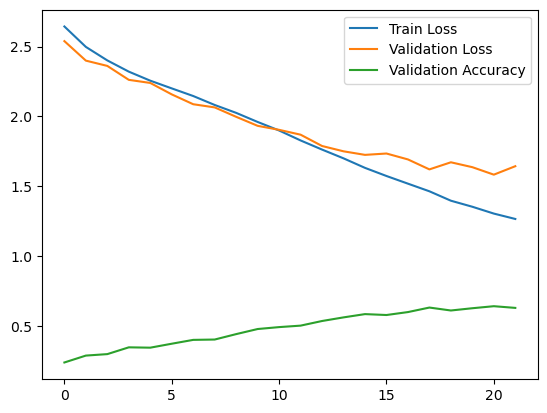

In [31]:
metrics_path = "./train_info/logs_13_12_21_19/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

<Axes: >

<Figure size 640x480 with 0 Axes>

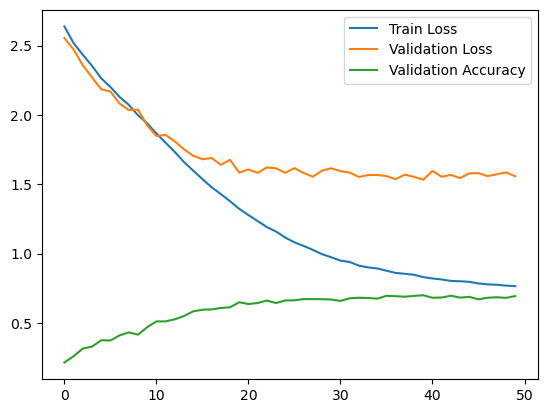

In [13]:
metrics_path = "./train_info/logs_11_12_7_1_custom_resnet18_dp=05/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

<Axes: >

<Figure size 640x480 with 0 Axes>

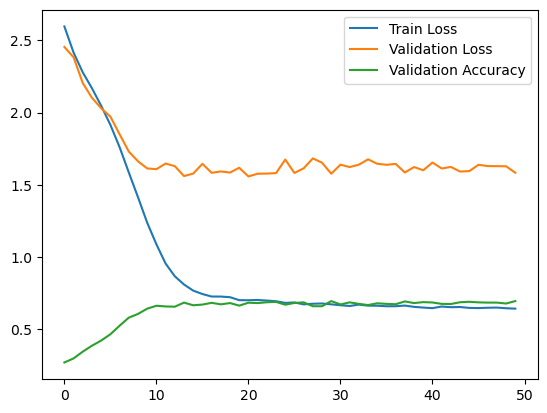

In [14]:

metrics_path = "./train_info/logs_11_12_2_56_custom_resnet18_m_dp=0.2/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

# Построение ансабля

Загружаю модели

In [19]:
path_res_check = './train_info/checkpoints_14_12_16_33/best_UpdatedResNet_checkpoint_22_val_accuracy=0.6650.pt'
path_res_model = './train_info/checkpoints_14_12_15_57/model_UpdatedResNet_epoch_1.pth'
path_res_m_check = './train_info/checkpoints_14_12_15_57/best_UpdatedResNet_checkpoint_13_val_accuracy=0.6489.pt'
path_res_m_model = './train_info/checkpoints_14_12_15_57/model_UpdatedResNet_epoch_1.pth'

In [20]:
def load_model(model_path, checkpoint_path, device):
    """Загружает модель PyTorch из файла .pt."""
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model = torch.load(model_path)["model_architecture"]
    model.load_state_dict(checkpoint["model"])# Получаем модель из словаря
    model.eval() # Вызываем eval() у модели
    return model.to(device)

In [21]:
a = load_model(path_res_model, path_res_check, device)

/tmp/ipykernel_10772/1268743797.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
/tmp/ipykerne

RuntimeError: Error(s) in loading state_dict for UpdatedResNet:
	Missing key(s) in state_dict: "layer1.0.se_block.fc.0.weight", "layer1.0.se_block.fc.2.weight", "layer1.1.se_block.fc.0.weight", "layer1.1.se_block.fc.2.weight", "layer2.0.se_block.fc.0.weight", "layer2.0.se_block.fc.2.weight", "layer2.1.se_block.fc.0.weight", "layer2.1.se_block.fc.2.weight", "layer3.0.se_block.fc.0.weight", "layer3.0.se_block.fc.2.weight", "layer3.1.se_block.fc.0.weight", "layer3.1.se_block.fc.2.weight", "layer4.0.se_block.fc.0.weight", "layer4.0.se_block.fc.2.weight", "layer4.1.se_block.fc.0.weight", "layer4.1.se_block.fc.2.weight". 
	Unexpected key(s) in state_dict: "layer1.0.se_block.fc1.weight", "layer1.0.se_block.fc2.weight", "layer1.1.se_block.fc1.weight", "layer1.1.se_block.fc2.weight", "layer2.0.se_block.fc1.weight", "layer2.0.se_block.fc2.weight", "layer2.1.se_block.fc1.weight", "layer2.1.se_block.fc2.weight", "layer3.0.se_block.fc1.weight", "layer3.0.se_block.fc2.weight", "layer3.1.se_block.fc1.weight", "layer3.1.se_block.fc2.weight", "layer4.0.se_block.fc1.weight", "layer4.0.se_block.fc2.weight", "layer4.1.se_block.fc1.weight", "layer4.1.se_block.fc2.weight". 

In [71]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.3):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.3):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20, dropout_prob=0.3):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)



In [72]:
model_res = custom_resnet18(dropout_prob=0.5).to(device)

In [74]:
import torch.nn.functional as F
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.2):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.2):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18_m(num_classes=20, dropout_prob=0.2):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)

In [75]:
model_res_m = custom_resnet18_m(dropout_prob=0.3).to(device)

In [76]:
def load_model(model, checkpoint_path, device):
    """Загружает модель PyTorch из файла .pt."""
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint["model"])# Получаем модель из словаря
    model.eval() # Вызываем eval() у модели
    return model

In [77]:
model_res = load_model(model_res ,path_res_check, device)
model_res_m = load_model(model_res_m ,path_res_check, device)

/tmp/ipykernel_11318/4125921851.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))


RuntimeError: Error(s) in loading state_dict for UpdatedResNet:
	Missing key(s) in state_dict: "layer1.0.se_block.fc.0.weight", "layer1.0.se_block.fc.2.weight", "layer1.1.se_block.fc.0.weight", "layer1.1.se_block.fc.2.weight", "layer2.0.se_block.fc.0.weight", "layer2.0.se_block.fc.2.weight", "layer2.1.se_block.fc.0.weight", "layer2.1.se_block.fc.2.weight", "layer3.0.se_block.fc.0.weight", "layer3.0.se_block.fc.2.weight", "layer3.1.se_block.fc.0.weight", "layer3.1.se_block.fc.2.weight", "layer4.0.se_block.fc.0.weight", "layer4.0.se_block.fc.2.weight", "layer4.1.se_block.fc.0.weight", "layer4.1.se_block.fc.2.weight". 
	Unexpected key(s) in state_dict: "layer1.0.se_block.fc1.weight", "layer1.0.se_block.fc2.weight", "layer1.1.se_block.fc1.weight", "layer1.1.se_block.fc2.weight", "layer2.0.se_block.fc1.weight", "layer2.0.se_block.fc2.weight", "layer2.1.se_block.fc1.weight", "layer2.1.se_block.fc2.weight", "layer3.0.se_block.fc1.weight", "layer3.0.se_block.fc2.weight", "layer3.1.se_block.fc1.weight", "layer3.1.se_block.fc2.weight", "layer4.0.se_block.fc1.weight", "layer4.0.se_block.fc2.weight", "layer4.1.se_block.fc1.weight", "layer4.1.se_block.fc2.weight". 

In [53]:
model_res = load_model('./train_info/checkpoints_13_12_21_19/best_checkpoint_21_val_accuracy=0.6408.pt', device)
# model_res_m = load_model('./train_info/checkpoints_13_12_20_47/best_checkpoint_13_val_accuracy=0.6472.pt', device)

/tmp/ipykernel_11318/770488771.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device(device))
/tmp/ipykernel_1131

AttributeError: 'collections.OrderedDict' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [23]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4070 SUPER
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [ ]:
model = AlexNet(20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [25]:
checkpoint_path = "./train_info/checkpoints_5_12_20_59/best_checkpoint_95_val_accuracy=0.5004.pt"

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

model.eval()

start_epoch = checkpoint["trainer"]['iteration'] / checkpoint["trainer"]['epoch_length']
start_epoch

C:\Users\Vlad\AppData\Local\Temp\ipykernel_8468\910594076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


95.0

In [26]:
checkpoint['trainer']

OrderedDict([('epoch_length', 174), ('max_epochs', 100), ('iteration', 16530)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


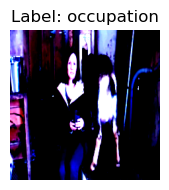

occupation


In [27]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


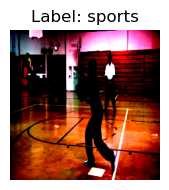

sports


In [30]:
dataiter = iter(DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0))
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

In [29]:
from ignite.metrics import Accuracy
from ignite.metrics import Precision, Recall, Fbeta, Accuracy

# Функция инференса для вычисления метрик
def inference_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        return outputs, labels

# Создаём Engine для инференса
evaluator = Engine(inference_step)

# Добавляем метрику Accuracy
accuracy = Accuracy()
precision = Precision(average=True)
recall = Recall(average=True)
f1 = Fbeta(beta=1.0, average=True)

accuracy.attach(evaluator, "accuracy")
precision.attach(evaluator, "precision")
recall.attach(evaluator, "recall")
f1.attach(evaluator, "f1")

pbar = ProgressBar(persist=True)
pbar.attach(evaluator)

# Оценка на валидационном датасете
state = evaluator.run(val_loader)

print(f"Validation Accuracy: {state.metrics['accuracy']:.4f}")
print(f"Validation Precision: {state.metrics['precision']:.4f}")
print(f"Validation Recall: {state.metrics['recall']:.4f}")
print(f"Validation F1 Score: {state.metrics['f1']:.4f}")

c:\Users\Vlad\.conda\envs\DL_ENV\lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Iteration: [20/20] 100%|██████████ [00:16<00:00]

Validation Accuracy: 0.5004
Validation Precision: 0.3904
Validation Recall: 0.3489
Validation F1 Score: 0.3578
